# 01_generate_synthetic_datasets.ipynb
# Simulated data for Mitofomer, DNA sequences, multi-omics features, targets

Generating DNA sequences with GC constraint...
Simulating transcriptomics for 12 genes...
Constructing multi omics feature panel...
Simulating target phenotypes, ATP, ROS, OCR...
Assembling tables...
Saving CSV files in data


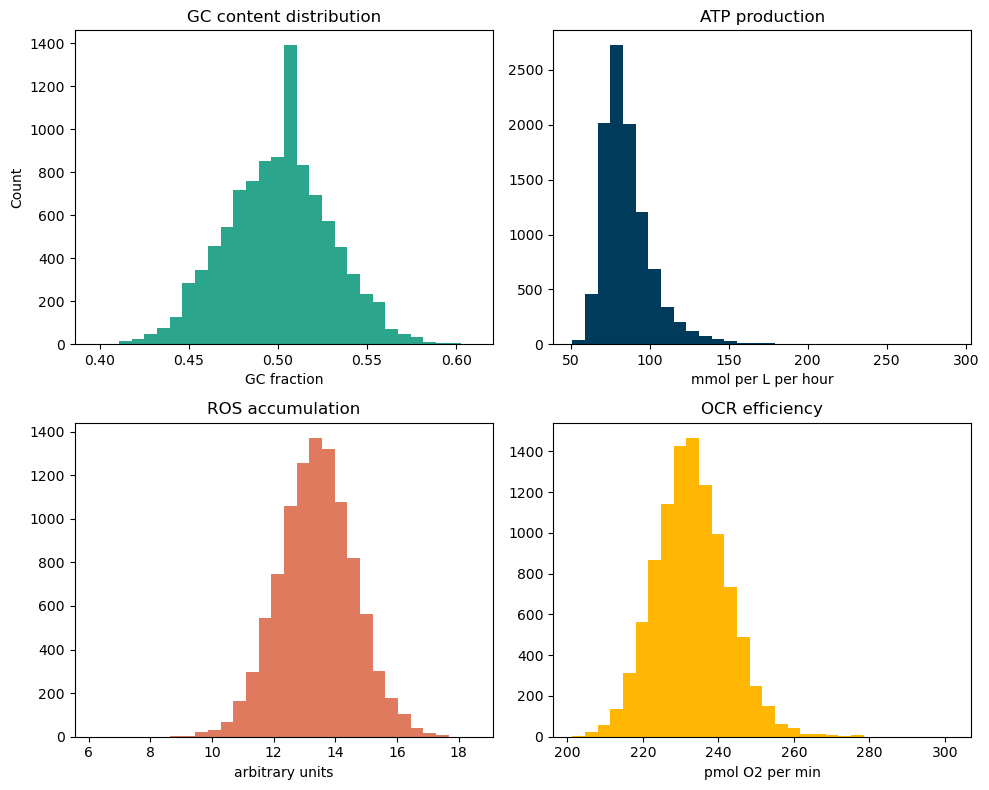

Done, synthetic datasets generated and saved.


In [1]:
import os
import json
import math
import random
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Configuration, feel free to adjust

NUM_SAMPLES = 10000                # total synthetic designs
SEQ_LEN = 300                      # length of each mitochondrial segment
GC_MIN, GC_MAX = 0.35, 0.65        # GC content constraint
NUM_GENES = 12                     # number of mito genes in transcript panel
NUM_OMICS_FEATS = 50               # total continuous features per sample
DATA_DIR = "data"

os.makedirs(DATA_DIR, exist_ok=True)

# Helper functions

NUCS = np.array(list("ACGT"))

def generate_seq_with_gc(n, gc_min=GC_MIN, gc_max=GC_MAX, L=SEQ_LEN):
    """Generate n DNA sequences with GC content within bounds."""
    seqs = []
    for _ in range(n):
        while True:
            s = "".join(np.random.choice(NUCS, size=L))
            gc = (s.count("G") + s.count("C")) / L
            if gc_min <= gc <= gc_max:
                seqs.append(s)
                break
    return seqs

def one_hot_encode_kmers(seq, k=6, vocab=("A","C","G","T")):
    """Return kmer index list for a sequence, compact integer form."""
    # map each kmer to a base 4 index, use rolling conversion
    base = {c:i for i,c in enumerate(vocab)}
    idxs = []
    val = 0
    powk = 4**(k-1)
    # initialize first kmer
    for i in range(k):
        val = val*4 + base[seq[i]]
    idxs.append(val)
    # slide
    for i in range(k, len(seq)):
        val = (val % powk)*4 + base[seq[i]]
        idxs.append(val)
    return idxs  # integers in range 0 to 4**k minus 1

def zscore(df):
    return (df - df.mean()) / (df.std(ddof=0) + 1e-8)

# 1. DNA sequences

print("Generating DNA sequences with GC constraint...")
dna_sequences = generate_seq_with_gc(NUM_SAMPLES, GC_MIN, GC_MAX, SEQ_LEN)
gc_vals = np.array([(s.count("G") + s.count("C")) / len(s) for s in dna_sequences])

# 2. Transcriptomics for 12 mitochondrial genes
#    simple Gaussian priors, light condition variation

gene_names = ["ND1","ND2","ND3","ND4","ND5","ND6","ATP6","ATP8","CYTB","COX1","COX2","COX3"]
assert len(gene_names) == NUM_GENES

print("Simulating transcriptomics for", NUM_GENES, "genes...")
# baseline means and stds for log scale expression
mu_log = np.array([3.6,3.4,3.2,3.3,3.5,3.1,3.8,2.9,3.7,3.9,3.6,3.5])
sd_log = np.array([1.0,1.1,1.1,1.0,1.0,1.2,1.0,1.0,1.0,0.9,1.0,1.0])

# sample a simple condition label per sample, control or stress
cond = np.random.choice(["control","stress"], size=NUM_SAMPLES, p=[0.6,0.4])
cond_shift = np.where(cond=="stress", 0.3, 0.0)[:,None]  # stress slightly raises expression

log_expr = np.random.normal(loc=mu_log, scale=sd_log, size=(NUM_SAMPLES, NUM_GENES)) + cond_shift
expr_tpm = np.exp(log_expr)  # positive continuous

# 3. Proteomics like and flux like features
#    we create a panel of 50 continuous features
#    first, derive a few informative latent variables from sequence and expression
print("Constructing multi omics feature panel...")
# sequence derived statistics
gc_centered = (gc_vals - gc_vals.mean()) / (gc_vals.std() + 1e-8)

# simple motif score, count of a short motif, scaled
def motif_score(seq, motif="ATG"):
    c = 0
    m = len(motif)
    for i in range(len(seq)-m+1):
        if seq[i:i+m] == motif:
            c += 1
    return c

motif_counts = np.array([motif_score(s, "ATG") for s in dna_sequences])
motif_z = (motif_counts - motif_counts.mean()) / (motif_counts.std() + 1e-8)

# expression aggregates
nd_expr = expr_tpm[:,0:6].mean(axis=1)        # ND1 to ND6
atp_expr = expr_tpm[:,6:8].mean(axis=1)       # ATP6, ATP8
cytb_expr = expr_tpm[:,8:9].mean(axis=1)      # CYTB
cox_expr = expr_tpm[:,9:12].mean(axis=1)      # COX1 to COX3

# normalize aggregates
nd_z = (nd_expr - nd_expr.mean()) / (nd_expr.std() + 1e-8)
atp_z = (atp_expr - atp_expr.mean()) / (atp_expr.std() + 1e-8)
cytb_z = (cytb_expr - cytb_expr.mean()) / (cytb_expr.std() + 1e-8)
cox_z = (cox_expr - cox_expr.mean()) / (cox_expr.std() + 1e-8)

# assemble 50 features, start with informative set, then add noise like features
feat_list = []
feat_names = []

def add_feat(arr, name):
    feat_list.append(arr.reshape(-1,1))
    feat_names.append(name)

add_feat(gc_centered, "feat_gc_centered")
add_feat(motif_z, "feat_motif_ATG_z")
add_feat(nd_z, "feat_mean_ND_z")
add_feat(atp_z, "feat_mean_ATP_z")
add_feat(cytb_z, "feat_mean_CYTB_z")
add_feat(cox_z, "feat_mean_COX_z")

# add additional transformed features, simple nonlinear mixes to reach 50
mix1 = 0.5*nd_z + 0.3*atp_z - 0.2*gc_centered
mix2 = 0.4*cytb_z + 0.4*cox_z + 0.2*motif_z
mix3 = np.tanh(0.7*nd_z - 0.3*cytb_z + 0.2*gc_centered)
mix4 = np.tanh(0.6*atp_z + 0.2*cox_z - 0.2*motif_z)

add_feat(mix1, "feat_mix1")
add_feat(mix2, "feat_mix2")
add_feat(mix3, "feat_mix3_tanh")
add_feat(mix4, "feat_mix4_tanh")

# fill remaining features with light noise features that correlate weakly
remaining = NUM_OMICS_FEATS - len(feat_list)
for i in range(remaining):
    noise = np.random.normal(0, 1, NUM_SAMPLES) * 0.5 + 0.1*nd_z + 0.1*atp_z
    add_feat(noise, f"feat_noise_{i:02d}")

X_omics = np.hstack(feat_list)
omics_cols = feat_names

# 4. Targets, ATP, ROS, OCR
#    build simulated ground truth from a nonlinear function of informative features

print("Simulating target phenotypes, ATP, ROS, OCR...")
# base values and scales chosen to resemble common units
ATP_base = 105.0      # mmol per L per hour
ROS_base = 15.0       # arbitrary units
OCR_base = 230.0      # pmol O2 per min

# nonlinear response
def simulate_targets(nd, atp, cytb, cox, gc, motif):
    # coupling term, higher with ATP and ND balance, lower with high GC extremes
    coupling = 0.9 + 0.12*atp + 0.10*nd - 0.05*np.abs(gc)
    # electron flow term
    flow = 1.0 + 0.10*nd + 0.08*cox + 0.06*cytb + 0.04*motif
    # ATP
    atp_out = ATP_base * coupling * 0.95 + np.random.normal(0, 3.0, size=coupling.shape)
    # ROS, decrease with better coupling and with balanced flow, increase with motif excess
    ros_out = ROS_base * (1.0 - 0.18*coupling + 0.06*np.abs(motif)) + np.random.normal(0, 1.0, size=coupling.shape)
    # OCR follows flow and coupling
    ocr_out = OCR_base * (0.85 + 0.12*flow + 0.05*coupling) + np.random.normal(0, 8.0, size=coupling.shape)
    return atp_out, ros_out, ocr_out

y_ATP, y_ROS, y_OCR = simulate_targets(nd_z, atp_z, cytb_z, cox_z, gc_centered, motif_z)


# 5. Build primary tables

print("Assembling tables...")
df_meta = pd.DataFrame({
    "design_id": [f"Design_{i:05d}" for i in range(NUM_SAMPLES)],
    "condition": cond,
    "gc_content": gc_vals
})

df_seq = pd.DataFrame({
    "design_id": df_meta["design_id"],
    "dna_seq": dna_sequences
})

df_expr = pd.DataFrame(expr_tpm, columns=[f"expr_{g}" for g in gene_names])
df_expr.insert(0, "design_id", df_meta["design_id"])

df_omics = pd.DataFrame(X_omics, columns=omics_cols)
df_omics.insert(0, "design_id", df_meta["design_id"])

df_targets = pd.DataFrame({
    "design_id": df_meta["design_id"],
    "ATP_production": y_ATP,
    "ROS_accumulation": y_ROS,
    "OCR_efficiency": y_OCR
})

# combined learning table
df_learning = df_meta.merge(df_seq, on="design_id") \
                     .merge(df_expr, on="design_id") \
                     .merge(df_omics, on="design_id") \
                     .merge(df_targets, on="design_id")

# 6. Save to disk

print("Saving CSV files in", DATA_DIR)
df_seq.to_csv(os.path.join(DATA_DIR, "synthetic_mito_dna_sequences.csv"), index=False)
df_expr.to_csv(os.path.join(DATA_DIR, "simulated_transcriptomics.csv"), index=False)
df_omics.to_csv(os.path.join(DATA_DIR, "simulated_multiomics_features.csv"), index=False)
df_targets.to_csv(os.path.join(DATA_DIR, "simulated_targets_ATP_ROS_OCR.csv"), index=False)
df_learning.to_csv(os.path.join(DATA_DIR, "mitofomer_training_table.csv"), index=False)

with open(os.path.join(DATA_DIR, "generation_config.json"), "w") as f:
    json.dump({
        "num_samples": NUM_SAMPLES,
        "seq_len": SEQ_LEN,
        "gc_min": GC_MIN,
        "gc_max": GC_MAX,
        "num_genes": NUM_GENES,
        "num_omics_feats": NUM_OMICS_FEATS,
        "seed": SEED
    }, f, indent=2)

# 7. Quick sanity plots, optional
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

axes[0].hist(gc_vals, bins=30, color="#2CA58D")
axes[0].set_title("GC content distribution")
axes[0].set_xlabel("GC fraction")
axes[0].set_ylabel("Count")

axes[1].hist(df_targets["ATP_production"], bins=30, color="#003B5C")
axes[1].set_title("ATP production")
axes[1].set_xlabel("mmol per L per hour")

axes[2].hist(df_targets["ROS_accumulation"], bins=30, color="#E07A5F")
axes[2].set_title("ROS accumulation")
axes[2].set_xlabel("arbitrary units")

axes[3].hist(df_targets["OCR_efficiency"], bins=30, color="#FFB703")
axes[3].set_title("OCR efficiency")
axes[3].set_xlabel("pmol O2 per min")

plt.tight_layout()
plt.show()

print("Done, synthetic datasets generated and saved.")